<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #6: Word2Vec
`Fecha de entrega: Septiembre 19, 2020. (Antes del inicio de la próxima clase).`

Este es un trabajo colectivo realizado por:

`Angela Villate
Leonardo Rubio
`


## Libre elección

Expectativas:
- Uso de Word2Vec 
- Responder:
    - ¿Su modelo da buenos resultados? ¿Por qué sí o por qué no?
    - ¿Qué problemas encontró al realizar este taller?
    

### Enviar código con explicaciones del por qué escogieron ese camino



## Primeros pasos de nuestro proyecto 






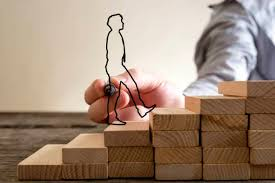






Quicimos aprovechar este ejercicio para analizar parte de los datos que hemos recolectado (hasta el momento) en nuestro proyecto sobre "análisis de sentimientos en twiter". Para contextualizar, nuestro proyecto consiste en el análisis de sentimientos positivos y negativos sobre películas. Para este ejercicio acudimos a dos fuentes: un dataset de IMBD (sobre películas) y la recolección de twits cuyos hashtags estuviesen relacionados con las películas seleccionadas.

Los twits que se recopilaron fueron tomados de la fecha de lanzamiento de la película. 

En el marco de la clase de NLP queremos comprender cuál es el comportamiento o relación vectorial de los términos que cualifican las películoas en su contexto de uso. 

Para lograrlo, hicimos lo siguiente:

1. Proceso de recolección de los twits por cada una de las películas seleccionadas
2. Generamos un embedding personalizado con un modelo skip -gram
3. Visualizamos las distancias de los vectores
4. Comparamos los resultados con la lista de emebding en inglés (para contar con un parámetro de referencia semántico)
5. Analizamos las relaciones lingüísticas para cada uno de los casos

Como siempre, hacemos el cargue librerias para tener nuestro entorno de trabajo

In [20]:
!pip install tweepy
!pip install gensim
import re
import numpy as np
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import json

Parámetros para aplicacion twiter

In [171]:
api_key = "xxxxxxxxxxxxxxxxxxxxxxx"
api_secret = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
access_token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
access_secret = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
auth = OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [172]:
public_tweets = api.home_timeline()

Clase de conexion con twiter

In [186]:
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api):
        self.api = api
        self.me = api.me()
        self.batch_size = 3
 
    def on_status(self, tweet):
        print(f"{tweet.user.name}:{tweet.text}georef-{tweet.created_at}")

    def on_error(self, status):
        print("Error detected")

En este punto se establecieron los parámetros para las búsquedas de twiter

In [69]:
LOCATIONS = [-124.7771694, 24.520833, -66.947028, 49.384472,        # Contiguous US
             -164.639405, 58.806859, -144.152365, 71.76871,         # Alaska
             -160.161542, 18.776344, -154.641396, 22.878623]        # Hawaii
track = ["Python"]
languages = ['es']
date_since = "2020-5-21"

Para la limpieza de los datos se decidió dejar: letras, números, @ y # (estos últimos porque tenemos la intuición de que pueden agregar valor semántico al mensaje)

In [174]:
cadena=""
def pre_procesado(texto):
    texto = texto.lower()
    #texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = re.sub(r"[^A-z 0-9 @ #]+", " ", texto) 
    #texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    #texto = " ".join([spanishStemmer.stem(palabra) for palabra in texto.split() ])
    return texto

Se realicó el cargue del archivo excel 

In [3]:
datos_excel= pd.read_excel("movies_filter.xlsx")
datos_excel

,budget,company,country,director,genre,gross,name,rating,day_released,month_released,year_released,released,runtime,score,star,votes,writer,year,hashtag
0,100000000.0,Red Granite Pictures,USA,Martin Scorsese,Biography,116900694.0,The Wolf of Wall Street,R,25,12,2013,2013-12-25,180,8.2,Leonardo DiCaprio,895552,Terence Winter,2013,#TheWolfofWallStreet
1,20000000.0,New Line Cinema,USA,James Wan,Horror,137400141.0,The Conjuring,R,19,7,2013,2013-07-19,112,7.5,Patrick Wilson,342870,Chad Hayes,2013,#TheConjuring
2,46000000.0,Alcon Entertainment,USA,Denis Villeneuve,Crime,61002302.0,Prisoners,R,20,9,2013,2013-09-20,153,8.1,Hugh Jackman,449489,Aaron Guzikowski,2013,#Prisoners
3,150000000.0,Walt Disney Animation Studios,USA,Chris Buck,Animation,400738009.0,Frozen,PG,27,11,2013,2013-11-27,102,7.5,Kristen Bell,464149,Jennifer Lee,2013,#Frozen
4,75000000.0,Summit Entertainment,USA,Louis Leterrier,Crime,117723989.0,Now You See Me,PG-13,31,5,2013,2013-05-31,115,7.3,Jesse Eisenberg,505432,Ed Solomon,2013,#NowYouSeeMe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,0.0,Fox Searchlight Pictures,UK,Mandie Fletcher,Comedy,4750497.0,Absolutely Fabulous: The Movie,R,22,7,2016,2016-07-22,91,5.4,Jennifer Saunders,9161,Jennifer Saunders,2016,#AbsolutelyFabulous:TheMovie
719,0.0,Siempre Viva Productions,USA,Paul Duddridge,Drama,28368.0,Mothers and Daughters,PG-13,6,5,2016,2016-05-6,90,4.9,Selma Blair,1959,Paige Cameron,2016,#MothersandDaughters
720,3500000.0,Warner Bros. Animation,USA,Sam Liu,Animation,3775000.0,Batman: The Killing Joke,R,25,7,2016,2016-07-25,76,6.5,Kevin Conroy,36333,Brian Azzarello,2016,#Batman:TheKillingJoke
721,0.0,Borderline Presents,USA,Nicolas Pesce,Drama,25981.0,The Eyes of My Mother,R,2,12,2016,2016-12-2,76,6.2,Kika Magalhães,6947,Nicolas Pesce,2016,#TheEyesofMyMother


Extraccion de twits ... ¡Atención! cada 25 peliculas esperar 15 minutos

In [ ]:
contador = 0
cadena_final = ""
for filas in datos_excel["hashtag"] : 
    hashtag=datos_excel["hashtag"][contador]
    fecha=datos_excel["released"][contador]
    if(contador % 25)== 0 and contador!= 0 :
        import time
        time.sleep(755) 
        cadena_texto= extraer_tweet(fecha, hashtag)
        print(f"Con demoras :{hashtag}")
    else:
        print(f"Sin demoras :{hashtag}")
        cadena_texto= extraer_tweet(fecha, hashtag)
    cadena_final+=cadena_texto
    escribir_archivo(cadena_final)
    contador+=1

Sin demoras :#TheWolfofWallStreet
Sin demoras :#TheConjuring
Sin demoras :#Prisoners
Sin demoras :#Frozen
Sin demoras :#NowYouSeeMe
Sin demoras :#Her
Sin demoras :#ManofSteel
Sin demoras :#We'retheMillers
Sin demoras :#BlueIstheWarmestColor
Sin demoras :#PacificRim
Sin demoras :#TheHungerGames:CatchingFire
Sin demoras :#AmericanHustle
Sin demoras :#Gravity
Sin demoras :#12YearsaSlave
Sin demoras :#StarTrekIntoDarkness
Sin demoras :#OlympusHasFallen
Sin demoras :#Oblivion
Sin demoras :#DallasBuyersClub
Sin demoras :#AboutTime
Sin demoras :#WorldWarZ
Sin demoras :#GangsterSquad
Sin demoras :#LoneSurvivor
Sin demoras :#Carrie
Sin demoras :#Thor:TheDarkWorld
Sin demoras :#Rush
Con demoras :#ThisIstheEnd
Sin demoras :#Lanochedelaexpiación
Sin demoras :#Fast&Furious6
Sin demoras :#TheGreenInferno
Sin demoras :#GrownUps2
Sin demoras :#Kick-Ass2
Sin demoras :#TheHobbit:TheDesolationofSmaug
Sin demoras :#BeautifulCreatures
Sin demoras :#TheCounsellor
Sin demoras :#EvilDead
Sin demoras :#TheSecr

Función para extraer twits 

In [200]:
def extraer_tweet(fecha, hashtag) : 
    cadena=""
    for tweet in tweepy.Cursor(api.search, q=hashtag, tweet_mode ="extended", locale="en", count= 5 , since=fecha).items(40):
        #print (tweet.full_text) created_at   metadata.
        text_tweet= tweet._json["full_text"]
        date_tweet= tweet._json["created_at"]
        text_tweet= pre_procesado(text_tweet)
        cadena+=hashtag+"|"+text_tweet+"|"+"|"+date_since+"\n"
    return cadena

Función para escribir twiter plano 

In [218]:
def escribir_archivo(cadena_final) :
    g = open("C:/Users/ASUS/Downloads/destino.csv","w")
    g.write(cadena_final)
    g.close()

In [216]:
g = open("C:/Users/ASUS/Downloads/destino.csv","w")
g.write(cadena_final)
g.close()

Funcion para cargar corpus de embedding en inglés para tener datos de contraste semántico

In [25]:
def cargar_archivo(filename):
     dic = {}
     with open(filename, encoding='utf-8') as archivo:
         for linea in archivo:
             vec = linea.split()
             palabra = vec[0]
             vec_num = np.array(vec[1:], dtype=float)
             dic[palabra] = vec_num
     return dic

Realizamos el cargue corpus 

In [26]:
%%time
sbw = cargar_archivo('glove.6B.100d.txt')
sbw

Wall time: 31.7 s


{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [27]:
type(sbw)

dict

Se crea el arreglo con las palabras de twiter con el verctor del corpus 

In [73]:
arreglo_fila={}
arreglo_fila['brave']          = sbw['brave']
arreglo_fila[ 'tweet']         = sbw['tweet']
arreglo_fila[ '#oblivion']     = sbw['oblivion']
arreglo_fila[ 'is']            = sbw['is']
arreglo_fila[ 'better']        = sbw['better']
arreglo_fila[ 'than']          = sbw['than']
#arreglo_fila[ 'skyrim']        = sbw['skyrim']
arreglo_fila[ 'in']            = sbw['in']
arreglo_fila[ 'every']         = sbw['every']
arreglo_fila[ 'way']           = sbw['way']
arreglo_fila[ 'excluding']     = sbw['excluding']
arreglo_fila[ 'the']           = sbw['the']
arreglo_fila[ 'ability']       = sbw['ability']
arreglo_fila[ 'to']            = sbw['to']
arreglo_fila[ 'forge']         = sbw['forge']
arreglo_fila[ 'weapons']       = sbw['weapons']
arreglo_fila[ 'and']           = sbw['and']
arreglo_fila[ 'armor']         = sbw['armor']
arreglo_fila[ '#oblivion']     = sbw['oblivion']
#arreglo_fila[ '#skyrim']       = sbw['skyrim']
#arreglo_fila[ '#elderscrolls']  = sbw['elderscrolls']
#sbw.index("they")

Se genera la función de palabras cercanas 

In [74]:
def palabras_cercanas(embedding, palabra, n=5):

     distances = []

     for key, value in embedding.items():

         dist = np.linalg.norm(embedding[palabra]-embedding[key])

         distances.append((dist,key))

     distances.sort()

     resultado = [d[1] for d in distances[1:n+1]]   

     return resultado

Agregar las palabras cercanas a nuestra lematizacion 

In [66]:
def busqueda_cercana(palabra):
    for fila_palabra in palabra :
        arreglo_fila2 = arreglo_fila
        resultado = palabras_cercanas(sbw, fila_palabra, n=5)
        for filas in resultado:
            arreglo_fila2[ filas]  = sbw[filas]
    return arreglo_fila2

In [71]:
arreglo_palabras2=["brave","better","ability"]
arreglo_fila2=busqueda_cercana(arreglo_palabras2)

Transformacion de datos en matrix

In [75]:
matrix = pd.DataFrame(arreglo_fila)
matrix=matrix.T.round(3)
matrix

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
brave,-0.311,-0.025,0.069,-0.440,-0.412,0.616,-0.522,-0.250,-0.992,-0.371,...,0.199,-0.205,0.310,0.250,-1.098,-0.001,-0.809,-0.145,-0.806,0.438
tweet,-0.072,0.084,0.134,-0.956,0.030,0.552,0.186,-0.239,0.522,0.446,...,0.069,0.354,0.180,-0.185,0.779,-0.258,0.156,-0.154,-0.693,0.135
#oblivion,-0.130,0.018,0.896,-0.260,0.309,0.621,-0.165,-0.499,0.342,-0.228,...,0.287,0.354,-0.019,1.016,0.230,-0.426,0.454,0.598,-0.558,-0.293
is,-0.543,0.415,1.032,-0.402,0.467,0.218,-0.075,0.473,0.081,-0.221,...,-0.325,-0.135,-0.413,0.334,-0.007,0.323,-0.044,-1.297,0.762,0.463
better,-0.048,0.519,0.343,-0.096,-0.447,-0.371,-0.129,-0.503,-0.261,-0.091,...,0.418,-0.319,0.109,-0.436,-0.545,0.075,-0.170,-0.269,0.487,0.556
than,0.103,1.247,0.567,-0.191,-0.336,0.434,0.131,0.109,-0.304,0.272,...,0.509,0.112,-0.176,-0.509,-0.941,-0.054,-0.570,-0.258,0.817,0.090
in,0.086,-0.222,0.166,0.134,0.382,0.354,0.013,0.225,-0.438,0.502,...,0.402,-0.127,-0.202,0.874,-0.545,0.792,-0.207,-0.074,0.758,-0.342
every,-0.277,0.927,0.173,-0.045,-0.083,1.046,0.217,0.875,0.036,-0.159,...,-0.149,0.429,0.126,-0.325,-0.955,-0.012,-0.158,0.188,0.632,0.293
way,0.155,0.223,0.667,-0.105,-0.131,0.374,-0.171,0.009,0.076,-0.113,...,-0.292,-0.319,-0.251,0.086,-0.502,-0.150,-0.078,-0.252,0.388,0.835
excluding,0.017,0.046,0.574,0.318,0.385,-0.811,-0.143,0.277,-0.037,-0.148,...,-0.474,-0.127,-0.050,-0.827,-0.787,-0.289,0.352,0.187,1.047,-0.387


Reduccion de dimensionalidad para proceder al análisis

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [77]:
pca = PCA(n_components=2)
result = pca.fit_transform(matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['Palabra'] = matrix.index.values
result

,X,Y,Palabra
0,2.220902,-1.405540,brave
1,4.042704,-2.674299,tweet
2,3.111780,-1.483440,#oblivion
3,-2.009358,-0.662533,is
4,-1.148198,-0.619154,better
5,-1.830755,-0.377632,than
6,-2.194233,-0.470132,in
7,-1.308450,-1.355635,every
8,-1.235898,-0.693307,way
9,1.027991,0.186320,excluding


In [78]:
trace = go.Scatter(x=result['X'].values,

                    y=result['Y'].values,

                    text=result['Palabra'].values,

                    mode='markers') 
 
layout = go.Layout(title="PCA")
 
fig = go.Figure(data=trace, layout=layout)

iplot(fig)


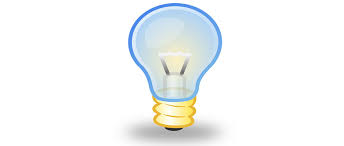

Esta primera visualización nos permite encontrar que en las coordenadas de (-1 y 1) se agrupan los conectores lógicos de tiempo, espacio o que indican la propiedad de un objeto o sujeto (to, in, the, is...) Estas palabras tienen la características de que no son reemplazables o no tienen sinónimos puesto que sintácticamente tienen funciones lingüísticas definidas inamovibles. 

El resto de la gráfica nos muestra palabras que están muy lejanas. Sorprende la distancia entre (weapons y armor); sin embargo esto podría explicarse por la falta de contexto semántico con la que cuenta esta primera visualización.

In [72]:
matrix2 = pd.DataFrame(arreglo_fila2)
matrix2=matrix2.T.round(3)
result2 = pca.fit_transform(matrix2)
result2 = pd.DataFrame(result2)
result2.columns = ['X', 'Y']
result2['Palabra'] = matrix2.index.values
trace = go.Scatter(x=result2['X'].values,

                    y=result2['Y'].values,

                    text=result2['Palabra'].values,

                    mode='markers') 
 
layout = go.Layout(title="PCA")
 
fig = go.Figure(data=trace, layout=layout)

iplot(fig)


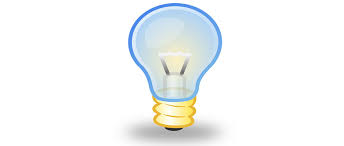

Esta segunda gráfica, muestra una representación de cercanías mucho más completa. Podemos indicar que hay tres grupos que saltan a la vista:

1. El de los conectores lógicos que describimos en la imagen anterior y que se mantiene en esta
2. Caracterización contextual de los sustantivos ability e inability (eje x -1 y 2, eje y 0 y 4). Encontramos que Se presentan dos contextos de uso: ability en relación con weapons y armor e inability en relación con forge. Esta clasificación nos da una intuición de los sentimientos (positivos o negativos) frente a carcaterísticas de la película cometnada (#Oblivion).
3. La tercera hace referencia a la agrupación de adjetivos con los que se cualifica la película y su relación: heroic, brave, fearlness, valient.

La impresión que nos deja este análisis preeliminar es que:

En un cotexto de uso semántico de "películas de acción" se empiezan a distinguir claramente unas tradiciones discursivas que, ene este punto se encuentran en los adjetivos calificativos.


# Intentamos generar un embedding personalizado con la muestra de los twits recolectados

In [46]:
import re
import pandas as pd
from nltk.corpus import stopwords
stopwords_sp = stopwords.words('english')
def pre_procesado2_s(texto):

     texto = texto.lower()

     #texto = re.sub(r"[\W\d_]+", " ", texto)

     texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])

     return texto.split()

Utilizamos la función lamda que hemos venido usando en clase

In [47]:
datos_twiter=pd.read_csv("destino.csv",sep="|")
datos_twiter["text_tweet_2"] = datos_twiter["text_tweet"].apply(lambda texto: pre_procesado2_s(texto) )  
datos_twiter.head()

,hashtag,text_tweet,blanco,date,text_tweet_2
0,#TheWolfofWallStreet,we re not going to be friends https t co yy0v...,NaN,2020-5-21,"[going, friends, https, co, yy0vzzyenh, przez,..."
1,#TheWolfofWallStreet,#thewolfofwallstreet https t co 6ds8x2f22m,NaN,2020-5-21,"[#thewolfofwallstreet, https, co, 6ds8x2f22m]"
2,#TheWolfofWallStreet,when all goes well let em know amp thump t...,NaN,2020-5-21,"[goes, well, let, em, know, amp, thump, chest,..."
3,#TheWolfofWallStreet,rt @imdb imdb fan favorite movie that starts ...,NaN,2020-5-21,"[rt, @imdb, imdb, fan, favorite, movie, starts..."
4,#TheWolfofWallStreet,have you seen the wolf of wall street here...,NaN,2020-5-21,"[seen, wolf, wall, street, scene, movie, teach..."


Cargamos las librerías para generar el modelo

In [48]:
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [49]:
datos_twiter['text_tweet_2'].values

array([list(['going', 'friends', 'https', 'co', 'yy0vzzyenh', 'przez', '@youtube', '#margotrobbie', '#leonardodicaprio', '#thewolfofwallstreet']),
       list(['#thewolfofwallstreet', 'https', 'co', '6ds8x2f22m']),
       list(['goes', 'well', 'let', 'em', 'know', 'amp', 'thump', 'chest', '#thump', '#thewolfofwallstreet', 'https', 'co', 'k24a7ahgkv']),
       ...,
       list(['#beginagain', '#saturdaythoughts', 'https', 'co', 'nkoze0dgda']),
       list(['rt', '@maha_medd', 'map', 'prepared', 'csir', 'neeri', 'mumbai', 'showing', '#covid19', 'cases', 'india', 'amp', 'maharashtra', '19', '09', '2020', '#maharashtrafightscorona', '#']),
       list(['everyone', 'past', 'present', 'future', 'growing', 'please', 'patient', 'love', '#like', '#follow', '#nohate', '#peaceandlove', '#makeamends', '#beginagain', 'https', 'co', 'lsf6vabpl6'])],
      dtype=object)

## Nuestro modelo sigue un Skip Gram: es decir queremos predecir el contexto a partir de la palabra (contexto de uso)

En este punto queremos hacer nuestro modelo usando todos los twits recolectados  y no solo con una película, como lo mostramos en el paso anterior. Escogimos el modelo de skip gram, es decir el que nos predice el contexto o palabras cercanas a partir de una palabra. A continuación presentamos el proceso:

In [50]:
%%time
 
mi_modelo = w2v.Word2Vec(datos_twiter['text_tweet_2'].values,

                          sg=400, # 1 skip-gram. 0 CBOW

                          seed=100, # semilla

                          ##size=9999999, # número de dimensiones

                          #min_count=750,

                          #window=9999999
                        )

Wall time: 854 ms


## Probando el modelo 
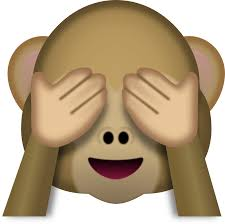

Seleccionamos la palabra "friends" para establecer cuales son las palabras que rodean o que habitualmente acompañan el contexto de uso de esta palabra... los resultados fueron los siguientes....

In [51]:
vocab = [e[0] for e in mi_modelo.wv.most_similar("alpha")]+[e[0] for e in mi_modelo.wv.most_similar("friends")]

print(vocab)

['much', '#lonesurvivor', 'colossal', 'commission', 'aimerait', 'first', 'mcjqmbpcls', 'getting', 'make', '#safehaven', 'neeri', 'u', 'per', 'post', 'movies', 'think', 'enough', '@startrek', 'getting', 'sampai']


Nos nos sorprende que en el contexto semántico de la palabra "friends" se encuentren palabras como make, fettind, safehaven, neer. Algunas de ellas nos representan expresiones compuestas y otras contextos de usos cotidianos que en, efecto, nos permiten concluir que el modelo responde con buen grado de acierto...

Aunque nos parecieron buenos resultados y estamos felicies por tener un primer acercamiento desde las técnicas de NLP a nuestro datos, tenemos interrogantes sobre las palabras en francés que aparecen como "aimerait" o "sampai"... seguiremos haciendo ajustes... 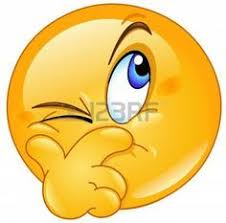

## Queremos visualizar nuestros datos... ¿tendremos algunas pistas?

In [52]:
mi_modelo.wv.vocab.keys()

dict_keys(['going', 'friends', 'https', 'co', '@youtube', '#leonardodicaprio', '#thewolfofwallstreet', 'goes', 'well', 'let', 'em', 'know', 'amp', 'rt', '@imdb', 'imdb', 'fan', 'favorite', 'movie', 'starts', 'letter', 'w', '#moviesatoz', 'ymz63d3ilo', 'p', 'seen', 'wolf', 'wall', 'street', 'scene', '#movies', 'de', 'se', 'que', 'filme', 'la', 'del', 'es', 'lo', 'mejor', 'en', 'tiempo', '@tonytolj', 'el', 'lobo', 'como', '#film', 'take', 'game', 'white', 'follow', 'us', 'download', 'gt', 'um', 'n', 'release', 'please', '20', '15', 'wir', 'das', 'mal', 'auf', 'eine', 'mit', 'dem', 'film', 'den', '3', 'para', 'always', '10', 'things', 'real', 'veces', 'un', '#theconjuring', '@thisdayinmetal0', 'sept', '19th', '1986', '#megadeth', 'released', 'album', 'peace', 'sells', 'buying', '#badomen', '#wakeupdead', '#mylastwords', '#theco', 'favourite', '2', 'da', 'una', '4', 'por', 'su', 'esta', 'v', 'big', 'house', 'one', 'ever', 'watch', '2019', '#b', 'still', 'believe', 'back', 'next', 'year', '

In [53]:
X = mi_modelo[mi_modelo.wv.vocab]

matrix = pd.DataFrame(X)

matrix.index = mi_modelo.wv.vocab.keys()
 
matrix

C:\Users\villa\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
going,-0.108756,-0.055880,0.005836,0.093834,-0.074422,-0.072279,-0.199439,-0.058208,0.076287,-0.122020,...,-0.065319,0.021549,-0.045149,-0.085556,-0.059042,0.007985,0.210502,-0.105402,0.176725,-0.132535
friends,-0.103512,-0.059712,0.004957,0.094128,-0.076909,-0.063941,-0.187855,-0.060671,0.082371,-0.125826,...,-0.068020,0.025790,-0.051134,-0.090214,-0.049179,0.006276,0.203839,-0.099967,0.173709,-0.124622
https,-0.132049,-0.052885,-0.007908,0.116479,-0.068156,-0.060708,-0.248403,-0.065142,0.085834,-0.144173,...,-0.099981,0.016790,-0.049897,-0.088951,-0.082095,0.005836,0.228550,-0.131416,0.214441,-0.147997
co,-0.114105,-0.056005,-0.002192,0.122862,-0.072753,-0.051543,-0.243309,-0.060437,0.081115,-0.142040,...,-0.099760,0.023633,-0.037478,-0.086265,-0.078150,0.004719,0.221315,-0.131539,0.210048,-0.145511
@youtube,-0.107211,-0.051541,0.014282,0.098025,-0.074812,-0.067562,-0.194124,-0.053780,0.080739,-0.121646,...,-0.066618,0.019644,-0.042082,-0.082737,-0.050663,0.004855,0.198651,-0.098487,0.170596,-0.121729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#maharashtrafightscorona,-0.095616,-0.051783,0.009736,0.076571,-0.069644,-0.057191,-0.166757,-0.052237,0.073919,-0.104911,...,-0.059261,0.020112,-0.043909,-0.079371,-0.045990,0.008381,0.174109,-0.085443,0.146963,-0.111793
makoto,-0.081785,-0.038285,0.004871,0.063643,-0.047661,-0.045934,-0.141899,-0.045465,0.059839,-0.091828,...,-0.049400,0.015771,-0.034312,-0.057636,-0.042711,0.007348,0.143252,-0.077891,0.129127,-0.093851
keira,-0.096911,-0.046722,0.005918,0.085399,-0.060489,-0.055404,-0.169039,-0.054361,0.069814,-0.110862,...,-0.059876,0.023228,-0.044652,-0.079975,-0.049026,0.010551,0.179723,-0.087369,0.150861,-0.111708
knightley,-0.090431,-0.044263,0.007603,0.075647,-0.064483,-0.057123,-0.160728,-0.050919,0.065483,-0.105041,...,-0.053414,0.019751,-0.033155,-0.070882,-0.046728,0.003459,0.171007,-0.086186,0.145911,-0.109915


In [54]:
pca = PCA(n_components=2)
result = pca.fit_transform(matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['Palabra'] = matrix.index.values
result

,X,Y,Palabra
0,-0.094273,-0.003884,going
1,-0.127134,0.005335,friends
2,0.048080,-0.082829,https
3,0.031271,-0.081470,co
4,-0.134832,-0.003004,@youtube
...,...,...,...
878,-0.265262,0.011083,#maharashtrafightscorona
879,-0.413236,0.008528,makoto
880,-0.259000,0.004606,keira
881,-0.296173,0.010798,knightley


In [55]:
trace = go.Scatter(x=result['X'].values,

                    y=result['Y'].values,

                    text=result['Palabra'].values,

                    mode='markers') 
 
layout = go.Layout(title="PCA")
 
fig = go.Figure(data=trace, layout=layout)

iplot(fig)

Al ver la imagen encontramos representadas palabras del inglés, el español y el francés, lo que dificulta el análisis de contexto semántico. Seguramente esto es una muestra de que si bien existen una tendencia a expresar "el gusto o el disgusto" por una película a partir de tradiciones lingüísticas similares, en esta visualización es dificil identificarlas. Segurmanete es una de las risegos que se toma al hacer el gráfico.

In [64]:
arreglo_final={}
matrix[0][0]
matrix[0].keys()
contador = 0
arreglo_temporal= list(range(100))
for filas_campos in matrix[0].keys():
    arreglo_temporal2 =[]
    for fila_arreglo in arreglo_temporal :
        #arreglo_temporal2[fila_arreglo]=matrix[fila_arreglo][contador]
        arreglo_temporal2.append(matrix[fila_arreglo][contador])
    arreglo_final[filas_campos] = np.array(arreglo_temporal2)
    contador+=1
arreglo_final

{'going': array([-1.08756050e-01, -5.58795705e-02,  5.83606167e-03,  9.38337967e-02,
        -7.44224116e-02, -7.22793862e-02, -1.99439317e-01, -5.82078658e-02,
         7.62870386e-02, -1.22020349e-01,  1.95262298e-01,  1.65514290e-01,
         7.40611479e-02,  7.37715885e-02,  1.46221712e-01,  2.95366496e-02,
         8.45244713e-03, -2.46239919e-02,  6.64985254e-02,  1.06719084e-01,
         1.65793151e-01, -1.38832197e-01, -1.84536248e-01,  5.69955185e-02,
         1.86250091e-01,  6.61556497e-02,  7.17335194e-03,  2.02447157e-02,
         1.40768932e-02,  4.20058072e-02, -4.33042757e-02, -7.15583116e-02,
         1.28013790e-01, -8.26226175e-02,  8.43145326e-02, -4.77141440e-02,
        -7.64917731e-02, -6.06438937e-03,  1.22013083e-03, -1.52850046e-03,
         1.15376133e-04, -8.99487957e-02,  2.90588558e-01, -4.44773398e-02,
         1.44679248e-01,  6.30894750e-02, -8.30356777e-02,  1.15109445e-03,
        -6.65795282e-02, -1.15467273e-01,  8.96092579e-02,  1.49129331e-01,
   

Otro ejemplo para poner a prubea el modelo

In [65]:
palabras_cercanas(arreglo_final, "@starwar", n=5)

['em', 'even', 'said', 'still', 'course']

Lo seguiremos mejorando

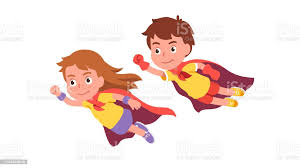